In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-10-16 10:28:52.761000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# VAE & LSTM V2

In [2]:
n_el = 16
r_obj = 0.3
dist_exc = 8
step_meas = 4

load_path = f"../data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

You have to generate the data...


In [3]:
V = np.load("../saves/" + load_path.split("/")[2] + "_v_data.npy", allow_pickle=True)

In [4]:
V.shape

(999, 192)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(
        shape=(keras.backend.shape(z_mean)[0], latent_dim)
    )
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 8

encoder_inputs = keras.Input(shape=(192,))

x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           12352       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['dense_1[0][0]']                
                                                                                            

2023-10-16 10:29:02.558442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-10-16 10:29:02.560260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [7]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(192, activation="relu")(x)
decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 192)               12480     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
Total params: 15,280
Trainable params: 15,280
Non-trainable

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
V_train , V_test = train_test_split(V, test_size=0.01, shuffle=True, random_state=52)

In [11]:
V_train

array([[0.03757839, 0.12150699, 0.08417239, ..., 0.85206869, 0.54576349,
        0.23383388],
       [0.02731698, 0.09298307, 0.02756802, ..., 0.7904118 , 0.56514158,
        0.26940069],
       [0.03601875, 0.13734994, 0.13712774, ..., 0.84374707, 0.5361958 ,
        0.22731431],
       ...,
       [0.1571865 , 0.1417017 , 0.03457656, ..., 0.66115616, 0.52237877,
        0.35074264],
       [0.02863542, 0.09626812, 0.03385487, ..., 0.81912644, 0.56396064,
        0.25802412],
       [0.04455297, 0.10105546, 0.02859424, ..., 0.69852035, 0.50934142,
        0.31805387]])

In [24]:
V_train

array([[0.03757839, 0.12150699, 0.08417239, ..., 0.85206869, 0.54576349,
        0.23383388],
       [0.02731698, 0.09298307, 0.02756802, ..., 0.7904118 , 0.56514158,
        0.26940069],
       [0.03601875, 0.13734994, 0.13712774, ..., 0.84374707, 0.5361958 ,
        0.22731431],
       ...,
       [0.1571865 , 0.1417017 , 0.03457656, ..., 0.66115616, 0.52237877,
        0.35074264],
       [0.02863542, 0.09626812, 0.03385487, ..., 0.81912644, 0.56396064,
        0.25802412],
       [0.04455297, 0.10105546, 0.02859424, ..., 0.69852035, 0.50934142,
        0.31805387]])

In [21]:
print(V_train.shape, V_test.shape)

(989, 192) (10, 192)


In [22]:
history = vae.fit(V_train, epochs=50, batch_size=64)

Epoch 1/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - reconstruction_loss: 0.0139 - kl_loss: 5.2154e-08
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0140 - reconstruction_loss: 0.0140 - kl_loss: 6.5193e-08
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - reconstruction_loss: 0.0139 - kl_loss: 6.5193e-08
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - reconstruction_loss: 0.0139 - kl_loss: 6.3330e-08
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - reconstruction_loss: 0.0139 - kl_loss: 7.8231e-08
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0140 - reconstruction_loss: 0.0139 - kl_loss: 3.5390e-08
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - reconstruction_loss: 0.0139 - kl_loss: 7.0781e-08
Epoch 8/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0139 - re


KeyboardInterrupt



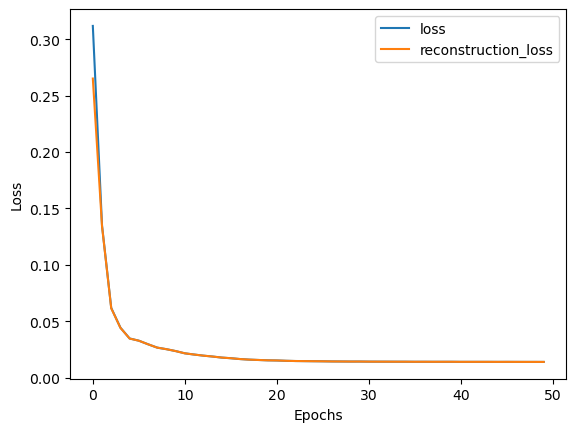

In [12]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
num_samples = 1
random_latent_points = np.random.normal(size=(num_samples, latent_dim))

In [14]:
generated_data = vae.decoder.predict(random_latent_points)

1/1 [==============================] - 0s 78ms/step


<StemContainer object of 3 artists>

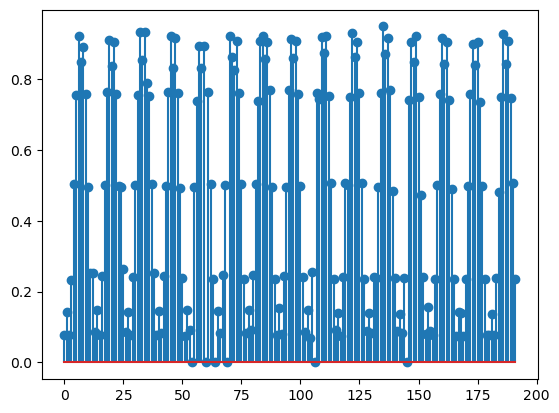

In [15]:
plt.stem(np.concatenate(generated_data))